<a href="https://colab.research.google.com/github/jamesETsmith/2022_simons_collab_pyscf_workshop/blob/main/demos/02_Quantum_chemistry_in_a_nutshell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the Jupyter notebook

* We need to install a few things before we get started
  * [PySCF](https://pyscf.org/) (for the quantum chemistry)
  * [py3DMol](https://3dmol.csb.pitt.edu/) for visualizing the molecule
  * [plotly](https://plotly.com/python/) and kaleido for plotting
  * [matplotlib](https://matplotlib.org) for visualizing the data.

In [ ]:
%pip install -q pyscf py3DMol matplotlib plotly kaleido

# What makes a meaningful quantum chemistry calculation?

- A proper **method**
  - Mean-field: [HF](https://pyscf.org/user/scf.html) (N^4), [DFT](https://pyscf.org/user/dft.html) (N^3-4)
  - Finite-order perturbation: [MP2](https://pyscf.org/user/mp.html) (N^5)
  - Resummed many-body perturbation: RPA (N^5), [CCSD](https://pyscf.org/user/cc.html) (N^6)
  - **"Gold standard": [CCSD(T)](https://pyscf.org/user/cc.html) (N^7)**
  - Exact diagonalization: [Full CI](https://pyscf.org/user/ci.html) (N!)
- A proper **1e [basis set](https://pyscf.org/user/gto.html#basis-set)**
  - double-zeta (DZ)
  - triple-zeta (TZ)
  - quadruple-zeta (QZ)
  - ...
  - **Complete basis set (CBS) limit**

# Sources of error
  - **Method** error
  - **Basis set incompleteness** error

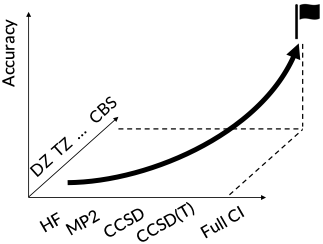

# Goals of this tutorial: quantum chemistry in action!
  - Study a real-life example with PySCF: the _atomization energy of a water molecule_
  - Study the basis set incompleteness error for different methods
  - Study the accuracy of different quantum chemistry methods

# System set-up

In [ ]:
from pyscf import gto, scf, dft, mp, cc
import plotly.graph_objects as go
import numpy as np

# Experimental geometry of gas-phase water
# Ref: https://cccbdb.nist.gov
mol_xyz = """O        0.0000   0.0000   0.1173
             H        0.0000   0.7572	 -0.4692
             H        0.0000  -0.7572	 -0.4692"""

# Oxygen: triplet; Hydrogen: doublet
spin_atom = {
    'O': 2, # 2 unpaired electrons --> triplet
    'H': 1  # 1 unpaired electron  --> doublet
    }

# Gaussian basis sets - cc-pV*X*Z (*X* = D, T, Q, 5)
  - Correlation-consistent Gaussian basis sets
  - The "go-to" choice for correlated calculations
  - See the [original paper](https://aip.scitation.org/doi/10.1063/1.456153) by Thom H. Dunning, Jr.

In [ ]:
basis_lst = ['ccpvdz','ccpvtz','ccpvqz','ccpv5z']
basis_names = ['DZ','TZ','QZ','5Z']

# Basis set cardinal number
basis_Xs = np.asarray([2,3,4,5], dtype=float)

# Calculating atomization (i.e., cohesive) energy

- The energy needed to break all chemical bonds in a molecule:

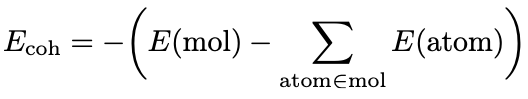

- Experimental atomization enthalpy at 0 K: 219.4 kcal/mol (from [CCCBDB](https://cccbdb.nist.gov))
- Zero-point motion correction: 13.5 kcal/mol (estimated using [CCSD(T)](https://www.sciencedirect.com/science/article/pii/S0301010408005259))
- Reference atomization energy: **232.9 kcal/mol**

In [ ]:
# Reference atomization energy
ecoh_ref = 232.9  # unit: kcal/mol

# Atomization energy calculated by different methods
# We will fill it as we proceed!
ecoh_method = {}

In [ ]:
# Remember: basis set + method --> quantum chemistry!

def calc_cohesive_energy1(basis, calc_energy):
  ''' Calculating the cohesive energy of a water molecule for a given method
  with a given basis set.

  Args:
    basis (str):
      Basis set name
    calc_energy (callable):
      Calculate the total energy for a given gto.Mole object.
      The function signature is
        calc_energy(mol) -> etot
  
  Returns:
    ecoh (float):
      The cohesive energy
  '''
  # Remember: -Ecoh = E(mol) - \sum_{atom \in mol} E(atom)

  # Calculate energy for the molecule
  mol = gto.M(atom=mol_xyz, basis=basis, verbose=0)
  emol = calc_energy(mol) # *Some* energy calculated with the basis set for H2O

  # Loop over all atoms in the molecule and calculate energy for each atom
  eatmsum = 0.
  for iatm in range(mol.natm):  # For more attrs of mol, check our user guide: https://pyscf.org/user/gto.html
    atm = mol.atom_symbol(iatm)
    spin = spin_atom[atm]
    mol_atm = gto.M(atom=atm, basis=basis, verbose=0,
                    spin=spin # atoms usually have non-zero spin
                  )
    eatm = calc_energy(mol_atm)
    eatmsum += eatm
  
  # Calculate the cohesive energy and convert it from Hartree to kcal/mol
  hartree2kcalpermol = 627.5096
  ecoh = -(emol - eatmsum) * hartree2kcalpermol

  return ecoh

def calc_cohesive_energy(calc_energy):
  ''' [Type doc here]
  '''
  ecohs = []
  for basis in basis_lst:
    ecoh = calc_cohesive_energy1(basis, calc_energy)
    print(f'{basis:10s}  {ecoh:.2f} kcal/mol')
    ecohs.append(ecoh)
  return np.asarray(ecohs)

# Hartree-Fock (HF)

In [ ]:
def calc_hf_energy(mol):
  """
  Calculate the HF energy of a given gto.Mole object.

  Args:
    mol (gto.Mole):
      Defining the system of interest.
  
  Returns:
    e_tot (float):
      HF total energy of the system.
  """
  # Check our user guide for more details: https://pyscf.org/user/scf.html

  # Init a HF object from mol
  # (optional: use density fitting to accelerate integral evaluation; see https://pyscf.org/user/df.html)
  mf = scf.HF(mol).density_fit()

  # Call kernel to perform the HF calculation
  mf.kernel()

  # Return HF total energy
  return mf.e_tot

In [ ]:
# Let's rock!
ecohs_hf = calc_cohesive_energy(calc_hf_energy)

### How does the **basis set incompleteness error** decay for the HF atomization energy?
  - Empirical observation: HF atomization energy converges **very fast**!
  - More quantitatively, want to plot
    - x-axis: basis set cardinal number (`basis_Xs`)
    - y-axis: error against largest basis set (`ecohs_hf(XZ) - ecohs_hf(5Z)`)

In [ ]:
xs = basis_Xs[:-1]
ys = ecohs_hf[:-1] - ecohs_hf[-1] # error against cc-pV5Z
fig = go.Figure()
fig.add_trace(go.Scatter(x=xs, y=ys))
fig.update_layout(
    xaxis_title="Basis set",
    yaxis_title=f"HF atomization energy [kcal/mol]",
    font=dict(size=18))
fig.update_traces(marker_size=12)
fig.update_layout(
    width=700, height=600,
    xaxis = dict(
        tickmode = 'array',
        tickvals = xs,
        ticktext = basis_names
    )
)
fig.show()

# Conclusion for HF
- The basis set incompleteness error for HF decays **very fast**
- Particularly, for the atomization energy of water:
  - error of the cc-pVTZ basis set is 1~2 kcal/mol
  - error of the cc-pVQZ basis set is <1 kcal/mol
  - 1 kcal/mol --> "**Chemical accuracy**"

In [ ]:
# Use cc-pV5Z result as our final HF energy in the CBS limit
ecoh_method['HF'] = ecohs_hf[-1]

# Kohn-Sham Density Functional Theory (KS-DFT)

In [ ]:
def calc_ks_energy(mol, xc='pbe'):
  """
  Calculate the KS-DFT energy of a given gto.Mole object.

  Args:
    mol (gto.Mole):
      Defining the system of interest.
  
  Kwargs:
    xc (str):
      The exchang-correlation functional. Default is PBE.
  
  Returns:
    e_tot (float):
      KS-DFT total energy of the system.
  """
  # Check our user guide for more details: https://pyscf.org/user/dft.html

  # Init a KS object from mol
  # (optional: use density fitting to accelerate integral evaluation)

  # Set the xc functional

  # Call kernel to perform the KS calculation

  # Return the KS total energy
  return mf.e_tot

In [ ]:
# Let's rock!
ecohs_ks = calc_cohesive_energy(calc_ks_energy)

### How does the **basis set incompleteness error** decay for the KS atomization energy?

- **As fast as HF**.



In [ ]:
xs = basis_Xs[:-1]
ys = ecohs_ks[:-1] - ecohs_ks[-1] # error against cc-pV5Z
fig = go.Figure()
fig.add_trace(go.Scatter(x=xs, y=ys))
fig.update_layout(
    xaxis_title="Basis set",
    yaxis_title=f"KS atomization energy [kcal/mol]",
    font=dict(size=18))
fig.update_traces(marker_size=12)
fig.update_layout(
    width=700, height=600,
    xaxis = dict(
        tickmode = 'array',
        tickvals = xs,
        ticktext = basis_names
    )
)
fig.show()

In [ ]:
# Use cc-pV5Z result as our final KS energy in the CBS limit
ecoh_method['KS'] = ecohs_ks[-1]

# Second-order Møller-Plesset perturbation theory (MP2)

In [ ]:
def calc_mp2_energy(mol):
  """
  Calculate the MP2 energy of a given gto.Mole object.

  Args:
    mol (gto.Mole):
      Defining the system of interest.
  
  Returns:
    e_tot (float):
      MP2 total energy of the system.
  """
  # Check our user guide for more details: https://pyscf.org/user/mp.html

  # Step 1: do a HF calculation
  # (optional: use density fitting to accelerate integral evaluation)

  # Step 2: do a MP2 calculation

  # Step 3: return the MP2 total energy
  return mmp.e_tot

In [ ]:
# Let's rock
ecohs_mp2 = calc_cohesive_energy(calc_mp2_energy)

### How does the **basis set incompleteness error** decay for the MP2 atomization energy?

- Empirical observation: convergence is **slower** than HF/DFT.
- According to the [literature](https://pubs-acs-org.ezproxy.cul.columbia.edu/doi/10.1021/ct100396y) (see eqns 1 and 2 and table 3), the MP2 **correlation energy** converges with basis set size as 1/*X*^b for
  - b = 3
  - b = 2.46
- Let's test both and see which leads to a better fit for our data.

In [ ]:
b1 = 3.
b2 = 2.46
x1s = 1/basis_Xs**b1
x2s = 1/basis_Xs**b2
ys = ecohs_mp2 - ecohs_hf # Correlation energy part of the MP2 atomization energy!
fig = go.Figure()
fig.add_trace(go.Scatter(x=x1s, y=ys, name=f'1/X^{b1:.2f}'))
fig.add_trace(go.Scatter(x=x2s, y=ys, name=f'1/X^{b2:.2f}'))
fig.update_layout(
    xaxis_title="Basis set",
    yaxis_title=f"MP2 atomization energy [kcal/mol]",
    font=dict(size=18))
fig.update_traces(marker_size=12)
fig.update_layout(
    width=700, height=600,
    xaxis = dict(
        tickmode = 'array',
        tickvals = x1s,
        ticktext = basis_names
    )
)
fig.show()

- Let's extrapolate to the CBS limit (i.e., X = infinity) using the `b` parameter you like
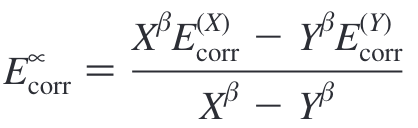

In [ ]:
# Function for two-point extrapolation based on the 1/X^b formulat
def twopoint_extrapolation(e1, e2, X1, X2, b):
  ''' Two-point extrapolation based on the 1/X^b formula
  '''
  return (e1/X2**b - e2/X1**b) / (1/X2**b - 1/X1**b)

# Extrapolate using QZ and 5Z with your preferred exponent b
ecorrqz = ecohs_mp2[2] - ecohs_hf[2]  # QZ MP2 correlation energy contribution to the atomization energy
ecorr5z = ecohs_mp2[3] - ecohs_hf[3]  # 5Z MP2 correlation energy contribution to the atomization energy
Xqz = basis_Xs[2]   # QZ basis cardinal number (=4)
X5z = basis_Xs[3]   # 5z basis cardinal number (=5)
b = # [Your preferred exponent: 3 or 2.46]

# Extrapolate the correlation energy
ecoh_mp2corr = twopoint_extrapolation(ecorrqz, ecorr5z, Xqz, X5z, b)

# Then add the HF energy to obtain the final MP2 atomization energy
ecoh_method['MP2'] = ecoh_method['HF'] + ecoh_mp2corr

# Coupled cluster with singles, doubles, and perturbative triples (CCSD(T))

Due to the limited resources we have in Google Colab, we will not run the calculations here.

Instead, we will play around with the data I pre-computed for you.

(Check out our [user guide](https://pyscf.org/user/cc.html) to know more about how to run coupled cluster calculations with PySCF.)

In [ ]:
# CCSD atomization energy with DZ, TZ, and QZ
ecohs_ccsd = np.asarray([207.56, 223.58, 227.55])

# CCSD(T) atomization energy with DZ, TZ, and QZ
ecohs_ccsd_t = np.asarray([209.01, 226.58, 230.92])

idx1 = 1  # TZ
idx2 = 2  # QZ
ecoh_hf = ecoh_method['HF']

e1 = ecohs_ccsd[idx1] - ecohs_hf[idx1]
e2 = ecohs_ccsd[idx2] - ecohs_hf[idx2]
X1 = basis_Xs[idx1]
X2 = basis_Xs[idx2]
ecoh_method['CCSD'] = twopoint_extrapolation(e1, e2, X1, X2, b) + ecoh_hf

e1 = ecohs_ccsd_t[idx1] - ecohs_hf[idx1]
e2 = ecohs_ccsd_t[idx2] - ecohs_hf[idx2]
ecoh_method['CCSD(T)'] = twopoint_extrapolation(e1, e2, X1, X2, b) + ecoh_hf

# Convergence of the atomization energy with the level of theory
- Expected:
  - Within wavefunction-based methods: HF --> MP2 --> CCSD --> CCSD(T)
  - KS-DFT: TBD

In [ ]:
# The following are numbers pre-calculated by me. Uncomment to use them if you prefer.
# ecoh_method = {
#     'HF'      : 155.80, # cc-pV5Z
#     'KS'      : 234.02, # PBE/cc-pV5Z
#     'MP2'     : 240.36, # (Q,5)-CBS (b=2.46)
#     'CCSD'    : 230.69, # (T,Q)-CBS (b=2.46)
#     'CCSD(T)' : 234.42, # (T,Q)-CBS (b=2.46)
# }

methods = ['HF','MP2','CCSD','CCSD(T)','KS']
xs = np.arange(len(methods))
es = np.asarray([ecoh_method[m] for m in methods])
ys = es - ecoh_ref

fig = go.Figure()
fig.add_trace(go.Bar(x=xs, y=ys))
fig.update_layout(
    xaxis_title="Method",
    yaxis_title=f"Atomization energy error [kcal/mol]",
    font=dict(size=18))
fig.update_layout(
    width=700, height=600,
    xaxis = dict(
        tickmode = 'array',
        tickvals = xs,
        ticktext = methods
    )
)
fig.show()

# Take-homes

- Quantum chemistry ≈ basis set + method
- Need to take care of **basis set convergence**
  - HF/DFT: very fast (exponential)
  - MP2/CCSD/CCSD(T): slow (polynomial) and often need extrapolation!
- Quantum chemistry methods are **systematically improvable** at the price of **increasing computational cost**:
  - HF --> MP2 --> CCSD --> CCSD(T) --> ...
- DFT is an "**outlier**":
  - as cheap as (or even cheaper than) HF
  - can (**sometimes**) match the accuracy of CCSD(T)!

# For the second half:
- All discussed above applies to periodic systems!

# Reference implementation

In [ ]:
def calc_dft_energy(mol, xc='pbe'):
  """
  Calculate the KS-DFT energy of a given gto.Mole object.

  Args:
    mol (gto.Mole):
      Defining the system of interest.
  
  Kwargs:
    xc (str):
      XC functional. Default is PBE.
  
  Returns:
    e_tot (float):
      KS-DFT total energy of the system.
  """
  # Init a KS object from mol
  # (optional: use density fitting to accelerate integral evaluation)
  mf = scf.KS(mol).density_fit()

  # Set the xc functional
  mf.xc = xc

  # Call kernel to perform the KS calculation
  mf.kernel()

  # Return the KS total energy
  return mf.e_tot

def calc_mp2_energy(mol):
  """
  Calculate the MP2 energy of a given gto.Mole object.

  Args:
    mol (gto.Mole):
      Defining the system of interest.
  
  Returns:
    e_tot (float):
      MP2 total energy of the system.
  """
  # Step 1: do a HF calculation
  # (optional: use density fitting to accelerate integral evaluation)
  mf = scf.HF(mol).density_fit().run()

  # Step 2: do a MP2 calculation
  # (If density fitting is used in the HF calculation above,
  #  it will be used *automatically* in the MP2 calculation.)
  mmp = mp.MP2(mf).run()

  # Step 3: return MP2 total energy
  return mmp.e_tot